In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [2]:
outliers_df = pd.read_csv('outliers-data.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7757 entries, 0 to 7756
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7757 non-null   float64
 1   bath            7757 non-null   float64
 2   acre_lot        7757 non-null   float64
 3   zip_code        7757 non-null   float64
 4   house_size      7757 non-null   float64
 5   prev_sold_date  7757 non-null   object 
 6   price           7757 non-null   float64
dtypes: float64(6), object(1)
memory usage: 424.3+ KB


In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7757 entries, 0 to 7756
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7757 non-null   float64
 1   bath            7757 non-null   float64
 2   acre_lot        7757 non-null   float64
 3   zip_code        7757 non-null   float64
 4   house_size      7757 non-null   float64
 5   price           7757 non-null   float64
 6   prev_sold_year  7757 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 424.3 KB


In [5]:
features = ["bed","bath","acre_lot","zip_code","house_size","prev_sold_year"]
num_features_to_select = len(features)-1
random_state_value = 42

In [6]:
X = outliers_df[features]
y = outliers_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

In [7]:
results_dict = {"model":[],"mae score":[],"mse score":[],"r2 score":[]}

In [8]:
def print_more_stuff(title, y_param, predict_param):
    results_dict["model"].append(title)
    
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)    
    
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)

In [9]:
ridge = Ridge(random_state=42)
ridge_sfs = SequentialFeatureSelector(estimator=ridge, n_features_to_select=num_features_to_select)
ridge_sfm = SelectFromModel(estimator=ridge, threshold=1000)
ridge_rfe = RFE(estimator=ridge, n_features_to_select=num_features_to_select)

In [10]:
ridge_pipeline = Pipeline([
  ('regression', ridge)
])

ridge_model = ridge_pipeline.fit(X_train,y_train)

In [11]:
ridge_predict_train = ridge_model.predict(X_train)
print_more_stuff("Ridge Regression Train",y_train,ridge_predict_train)

Ridge Regression Train MSE = 117,696,500,642.569229
Ridge Regression Train MAE = 222,665.563638
Ridge Regression Train R2 = 0.333536


In [12]:
ridge_predict = ridge_model.predict(X_test)
print_more_stuff("Ridge Regression Test",y_test,ridge_predict)

Ridge Regression Test MSE = 123,734,504,392.488480
Ridge Regression Test MAE = 226,347.511933
Ridge Regression Test R2 = 0.379312


In [13]:
ridge_sfm_pipeline = Pipeline([
  ('feature_selection', ridge_sfm),
  ('regression', ridge)
])

ridge_sfm_fs = ridge_sfm_pipeline.named_steps['feature_selection'].fit(X_train,y_train)
ridge_sfm_get_support = ridge_sfm_fs.get_support()

print('The selected features are:', list(X.columns[ridge_sfm_get_support]))

The selected features are: ['bed', 'bath', 'acre_lot', 'prev_sold_year']


In [14]:
ridge_sfm_model = ridge_sfm_pipeline.fit(X_train,y_train)
ridge_sfm_predict = ridge_sfm_model.predict(X_test)
print_more_stuff("SelectFromModel",y_test,ridge_sfm_predict)

SelectFromModel MSE = 124,169,260,553.455917
SelectFromModel MAE = 226,660.102952
SelectFromModel R2 = 0.377131


In [15]:
ridge_sfs_pipeline = Pipeline([
  ('feature_selection', ridge_sfs),
  ('regression', ridge)
])

ridge_sfs_fs = ridge_sfs_pipeline.named_steps['feature_selection'].fit(X_train,y_train)
ridge_sfs_get_support = ridge_sfs_fs.get_support()

print('The selected features are:', list(X.columns[ridge_sfs_get_support]))

The selected features are: ['bed', 'bath', 'zip_code', 'house_size', 'prev_sold_year']


In [16]:
ridge_sfs_model = ridge_sfs_pipeline.fit(X_train,y_train)
ridge_sfs_predict = ridge_sfs_model.predict(X_test)
print_more_stuff("SequentialFeatureSelector",y_test,ridge_sfs_predict)

SequentialFeatureSelector MSE = 123,867,783,314.789352
SequentialFeatureSelector MAE = 226,460.140896
SequentialFeatureSelector R2 = 0.378644


In [17]:
ridge_rfe_pipeline = Pipeline([
  ('feature_selection', ridge_rfe),
  ('regression', ridge)
])
ridge_rfe_fs = ridge_rfe_pipeline.named_steps['feature_selection'].fit(X_train,y_train)
ridge_rfe_get_support = ridge_rfe_fs.get_support()

print('The selected features are:', list(X.columns[ridge_rfe_get_support]))

The selected features are: ['bed', 'bath', 'acre_lot', 'zip_code', 'prev_sold_year']


In [18]:
ridge_rfe_model = ridge_rfe_pipeline.fit(X_train,y_train)
ridge_rfe_predict = ridge_rfe_model.predict(X_test)
print_more_stuff("Recursive Feature Elimination",y_test,ridge_rfe_predict)

Recursive Feature Elimination MSE = 123,815,160,643.722778
Recursive Feature Elimination MAE = 226,370.478611
Recursive Feature Elimination R2 = 0.378908


https://scikit-learn.org/stable/modules/feature_selection.html#select-from-model

In [19]:
ridge_pipe = Pipeline([('ridge', Ridge())])
param_dict = {'ridge__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}

In [20]:
ridge_gscv = GridSearchCV(ridge_pipe, param_grid=param_dict)

In [21]:

ridge_gscv_model = ridge_gscv.fit(X, y)
ridge_gscv_predict = ridge_gscv_model.predict(X_test)
print_more_stuff("Grid Search CV",y_test,ridge_gscv_predict)

Grid Search CV MSE = 123,219,783,117.242050
Grid Search CV MAE = 227,449.465237
Grid Search CV R2 = 0.381894


In [22]:
ridge_predict_df = pd.DataFrame(ridge_predict).reset_index()
ridge_predict_df.rename(columns={0: "prediction"},inplace=True)

ridge_sfm_predict_df = pd.DataFrame(ridge_sfm_predict).reset_index()
ridge_sfm_predict_df.rename(columns={0: "prediction"},inplace=True)

ridge_sfs_predict_df = pd.DataFrame(ridge_sfs_predict).reset_index()
ridge_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

ridge_rfe_predict_df = pd.DataFrame(ridge_rfe_predict).reset_index()
ridge_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

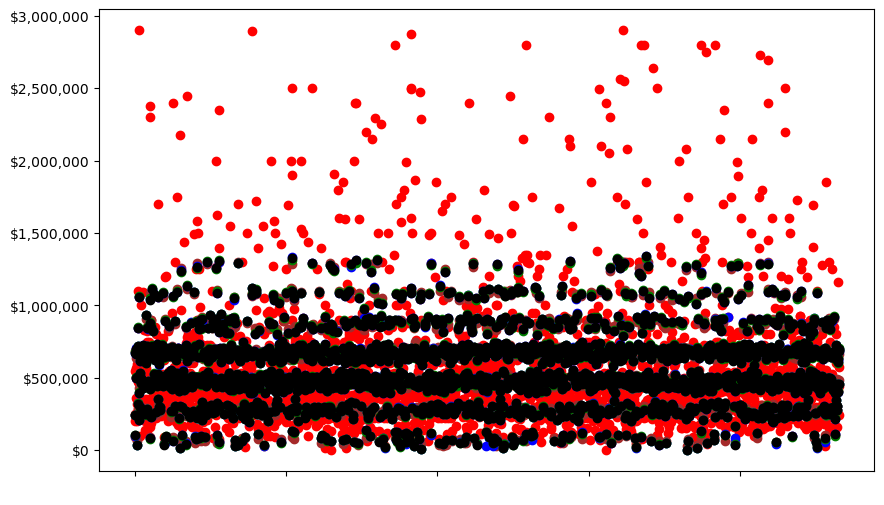

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(ridge_sfm_predict_df.index,ridge_sfm_predict_df["prediction"], color="brown")
plt.scatter(ridge_sfs_predict_df.index,ridge_sfs_predict_df["prediction"], color="blue")
plt.scatter(ridge_rfe_predict_df.index,ridge_rfe_predict_df["prediction"], color="green")
plt.scatter(ridge_predict_df.index,ridge_predict_df["prediction"], color="black")
plt.show()

In [24]:
ridge_predict_df.sort_values(by='prediction', inplace=True)
ridge_predict_df.reset_index(inplace=True)

ridge_sfm_predict_df.sort_values(by='prediction', inplace=True)
ridge_sfm_predict_df.reset_index(inplace=True)

ridge_sfs_predict_df.sort_values(by='prediction', inplace=True)
ridge_sfs_predict_df.reset_index(inplace=True)

ridge_rfe_predict_df.sort_values(by='prediction', inplace=True)
ridge_rfe_predict_df.reset_index(inplace=True)

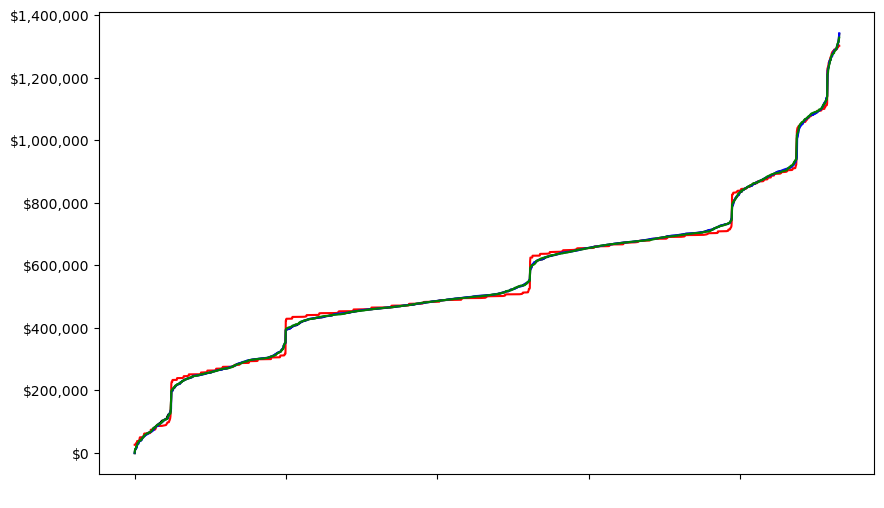

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.plot(ridge_predict_df.index,ridge_predict_df["prediction"], color="black")
plt.plot(ridge_sfm_predict_df.index,ridge_sfm_predict_df["prediction"], color="red")
plt.plot(ridge_sfs_predict_df.index,ridge_sfs_predict_df["prediction"], color="blue")
plt.plot(ridge_rfe_predict_df.index,ridge_rfe_predict_df["prediction"], color="green")
plt.show()

In [26]:
ridge_predic_train_df = pd.DataFrame(ridge_predict_train).reset_index()
ridge_predic_train_df.rename(columns={0: "prediction"},inplace=True)

ridge_predic_train_df.sort_values(by='prediction', inplace=True)
ridge_predic_train_df.reset_index(inplace=True)

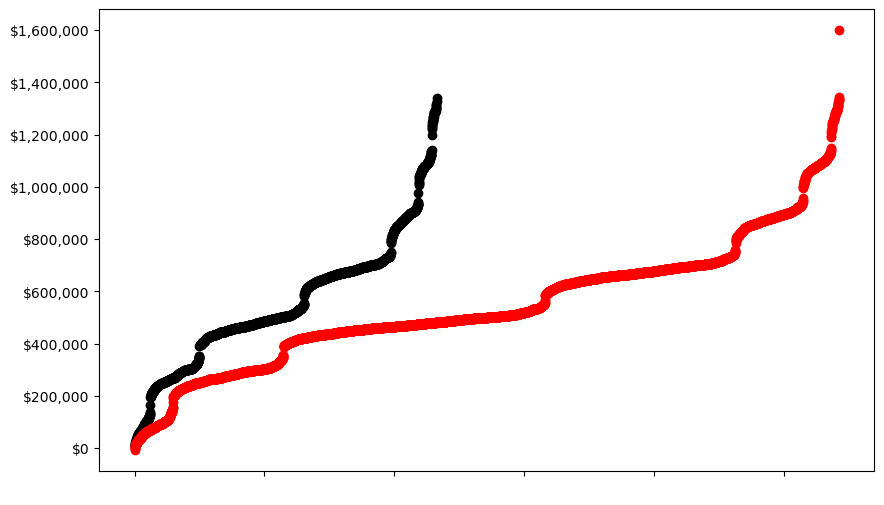

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(ridge_predict_df.index,ridge_predict_df["prediction"], color="black")
plt.scatter(ridge_predic_train_df.index,ridge_predic_train_df["prediction"], color="red")
plt.show()

In [28]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,mae score,mse score,r2 score
model,,,
Ridge Regression Train,"222,665.563638","117,696,500,642.569229",0.333536
Ridge Regression Test,"226,347.511933","123,734,504,392.488480",0.379312
SelectFromModel,"226,660.102952","124,169,260,553.455917",0.377131
SequentialFeatureSelector,"226,460.140896","123,867,783,314.789352",0.378644
Recursive Feature Elimination,"226,370.478611","123,815,160,643.722778",0.378908
Grid Search CV,"227,449.465237","123,219,783,117.242050",0.381894
